In [186]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from sklearn import metrics
from skimage.filters.rank import entropy
from skimage.morphology import disk, square

from vsa_ogm.metrics import calculate_multiple_TP_FP_rates

In [187]:
paths: dict = {
    "agent1": {
        "axis_vectors": "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent1_fusion_v2/xy_axis_vectors.npy",
        "axis_matrix": "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent1_fusion_v2/xy_axis_matrix.npy",
        "occupied_quadrant_memories": "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent1_fusion_v2/observations/observation_364/occupied_quadrant_memory_vectors.npy",
        "empty_quadrant_memories": "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent1_fusion_v2/observations/observation_364/empty_quadrant_memory_vectors.npy",
    },
    "agent2": {
        "axis_vectors": "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent2_fusion_v2/xy_axis_vectors.npy",
        "axis_matrix": "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent2_fusion_v2/xy_axis_matrix.npy",
        "occupied_quadrant_memories": "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent2_fusion_v2/observations/observation_364/occupied_quadrant_memory_vectors.npy",
        "empty_quadrant_memories": "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent2_fusion_v2/observations/observation_364/empty_quadrant_memory_vectors.npy",
    }
}

#### Validate Axis Vector Equivalence

In [188]:
a1_xy_axis_vectors = np.load(paths["agent1"]["axis_vectors"])
a2_xy_axis_vectors = np.load(paths["agent2"]["axis_vectors"])

assert a1_xy_axis_vectors.shape == a2_xy_axis_vectors.shape
assert a1_xy_axis_vectors.shape[0] == a1_xy_axis_vectors.shape[0]
assert a1_xy_axis_vectors.shape[1] == a1_xy_axis_vectors.shape[1]
assert np.equal(a1_xy_axis_vectors, a2_xy_axis_vectors).all()

#### Load the global xy axis matrix

In [189]:
a1_xy_axis_matrix = np.load(paths["agent1"]["axis_matrix"])
a2_xy_axis_matrix = np.load(paths["agent2"]["axis_matrix"])

assert a1_xy_axis_matrix.shape == a2_xy_axis_matrix.shape
assert a1_xy_axis_matrix.shape[0] == a1_xy_axis_matrix.shape[0]
assert a1_xy_axis_matrix.shape[1] == a1_xy_axis_matrix.shape[1]
assert np.equal(a1_xy_axis_matrix, a2_xy_axis_matrix).all()

#### Load occupied quadrant memories

In [190]:
a1_occupied_quadrant_memories = np.load(paths["agent1"]["occupied_quadrant_memories"])
a2_occupied_quadrant_memories = np.load(paths["agent2"]["occupied_quadrant_memories"])

assert a1_occupied_quadrant_memories.shape == a2_occupied_quadrant_memories.shape
assert a1_occupied_quadrant_memories.shape[0] == a1_occupied_quadrant_memories.shape[0]
assert a1_occupied_quadrant_memories.shape[1] == a1_occupied_quadrant_memories.shape[1]

#### Load empty quadrant memories

In [191]:
a1_empty_quadrant_memories = np.load(paths["agent1"]["empty_quadrant_memories"])
a2_empty_quadrant_memories = np.load(paths["agent2"]["empty_quadrant_memories"])

assert a1_empty_quadrant_memories.shape == a2_empty_quadrant_memories.shape
assert a1_empty_quadrant_memories.shape[0] == a1_empty_quadrant_memories.shape[0]
assert a1_empty_quadrant_memories.shape[1] == a1_empty_quadrant_memories.shape[1]

#### Calculate the global occupied quadrant memories

In [192]:
import time

total_time = 0

start_time = time.time()
global_occupied_quadrant_memories = np.add(a1_occupied_quadrant_memories, a2_occupied_quadrant_memories)
global_empty_quadrant_memories = np.add(a1_empty_quadrant_memories, a2_empty_quadrant_memories)
total_time += time.time() - start_time

#### Load the quadrant indicies

In [193]:
quadrant_indices_x_path: str = "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent2_fusion/quadrant_indices_x.npy"
quadrant_indices_y_path: str = "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent2_fusion/quadrant_indices_y.npy"

quadrant_indices_x = np.load(quadrant_indices_x_path)
quadrant_indices_y = np.load(quadrant_indices_y_path)

#### Calculate the global empty probability heatmap

In [194]:
global_empty_xy_axis_heatmap = np.zeros(
    shape=(a1_xy_axis_matrix.shape[0], a1_xy_axis_matrix.shape[1])
)

counter = 0
for j, y_lower in enumerate(quadrant_indices_y[:-1]):
    for i, x_lower in enumerate(quadrant_indices_x[:-1]):
        x_upper = quadrant_indices_x[i + 1]
        y_upper = quadrant_indices_y[j + 1]

        xy_axis_matrix_quad = a1_xy_axis_matrix[x_lower:x_upper, y_lower:y_upper, :]

        qv = global_empty_quadrant_memories[counter, :]
        qv = qv / np.linalg.norm(qv)

        quadrant_heatmap = np.tensordot(
            qv,
            xy_axis_matrix_quad,
            axes=([0], [2])
        )

        quadrant_heatmap /= np.max(quadrant_heatmap)

        global_empty_xy_axis_heatmap[x_lower:x_upper, y_lower:y_upper] = quadrant_heatmap
        
        counter += 1

global_empty_xy_axis_heatmap = np.transpose(global_empty_xy_axis_heatmap)

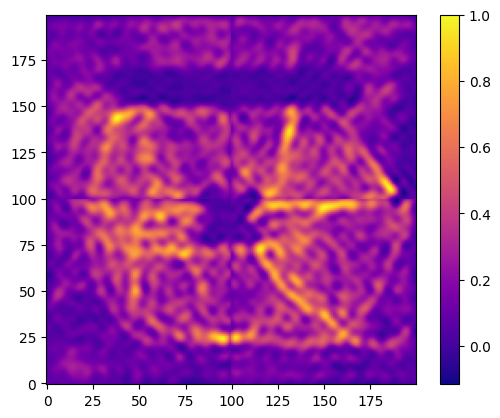

In [195]:
plt.imshow(global_empty_xy_axis_heatmap, cmap="plasma", origin="lower")
plt.colorbar()

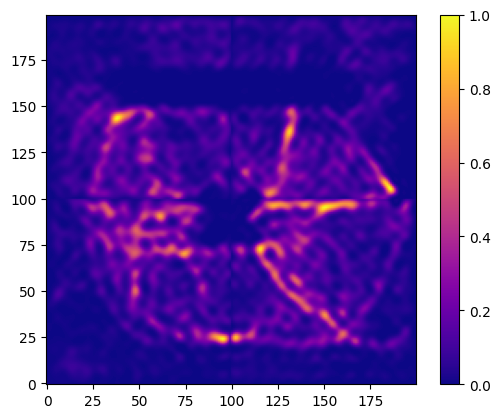

In [196]:
plt.imshow(np.square(global_empty_xy_axis_heatmap), cmap="plasma", origin="lower")
plt.colorbar()

6.191701854736467
0.0


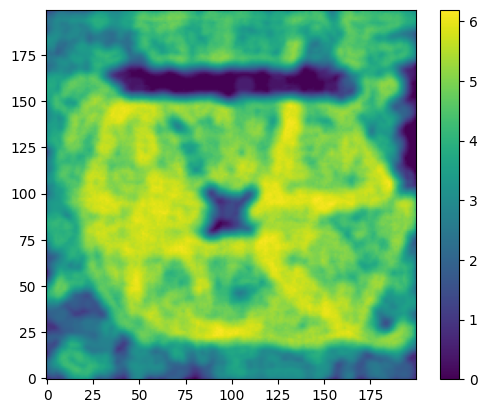

In [197]:
start_time = time.time()
global_empty_image = np.square(global_empty_xy_axis_heatmap)
global_empty_image *= 255.0
global_empty_image = global_empty_image.astype(np.uint8)
disk_size = 5
global_empty_entropy = entropy(global_empty_image, disk(disk_size))
total_time += time.time() - start_time


print(np.max(global_empty_entropy))
print(np.min(global_empty_entropy))

plt.imshow(global_empty_entropy, cmap="viridis", origin="lower")
plt.colorbar()

#### Calculate the global occupied probability heatmap

In [198]:
global_occupied_xy_axis_heatmap = np.zeros(
    shape=(a1_xy_axis_matrix.shape[0], a1_xy_axis_matrix.shape[1])
)

counter = 0
for j, y_lower in enumerate(quadrant_indices_y[:-1]):
    for i, x_lower in enumerate(quadrant_indices_x[:-1]):
        x_upper = quadrant_indices_x[i + 1]
        y_upper = quadrant_indices_y[j + 1]

        xy_axis_matrix_quad = a1_xy_axis_matrix[x_lower:x_upper, y_lower:y_upper, :]

        qv = global_occupied_quadrant_memories[counter, :]
        qv = qv / np.linalg.norm(qv)

        quadrant_heatmap = np.tensordot(
            qv,
            xy_axis_matrix_quad,
            axes=([0], [2])
        )

        quadrant_heatmap /= np.max(quadrant_heatmap)

        global_occupied_xy_axis_heatmap[x_lower:x_upper, y_lower:y_upper] = quadrant_heatmap
        
        counter += 1

global_occupied_xy_axis_heatmap = np.transpose(global_occupied_xy_axis_heatmap)

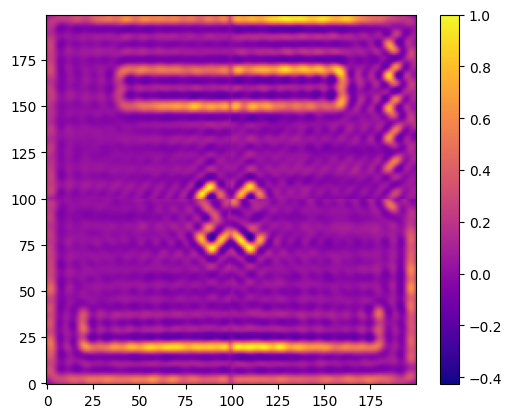

In [199]:
plt.imshow(global_occupied_xy_axis_heatmap, cmap="plasma", origin="lower")
plt.colorbar()

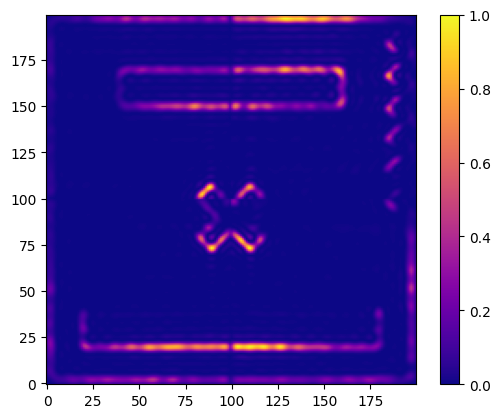

In [200]:
plt.imshow(np.square(global_occupied_xy_axis_heatmap), cmap="plasma", origin="lower")
plt.colorbar()

6.040286268236586
0.0


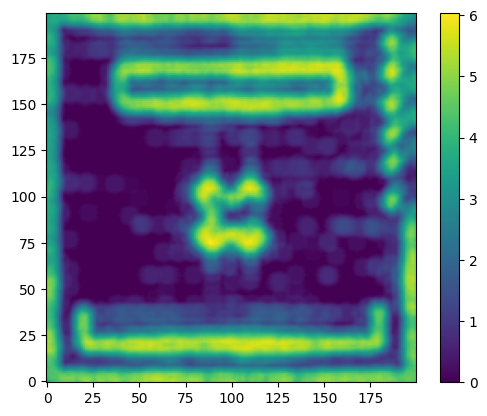

In [201]:
start_time = time.time()
global_occupied_image = np.square(global_occupied_xy_axis_heatmap)
global_occupied_image *= 255.0
global_occupied_image = global_occupied_image.astype(np.uint8)
disk_size = 5
global_occupied_entropy = entropy(global_occupied_image, disk(disk_size))
total_time += time.time() - start_time

print(np.max(global_occupied_entropy))
print(np.min(global_occupied_entropy))

plt.imshow(global_occupied_entropy, origin="lower")
plt.colorbar()

5.207877785556727
-6.167010496711778


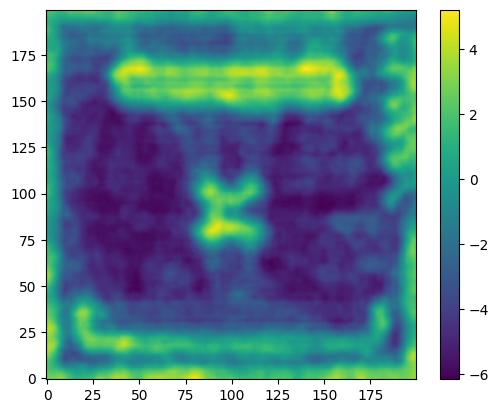

In [202]:
start_time = time.time()
global_entropy = global_occupied_entropy - global_empty_entropy
total_time += time.time() - start_time

print(np.max(global_entropy))
print(np.min(global_entropy))

plt.imshow(global_entropy, origin="lower")
plt.colorbar()

In [218]:
print(f"Total time: {total_time}")

Total time: 0.08314895629882812


#### Calculate the performance metrics

In [203]:
a1_td_path = "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent1_fusion_v2/test_data.pkl"
a2_td_path = "/home/ssnyde9/dev/highfrost/highfrost/ogm/experiments/logs/build_vsa_map_toysim_agent2_fusion_v2/test_data.pkl"

with open(a1_td_path, "rb") as f:
    a1_test_data = pkl.load(f)

with open(a2_td_path, "rb") as f:
    a2_test_data = pkl.load(f)

Num Threshold Steps: 1138


Text(0, 0.5, 'Threshold Values')

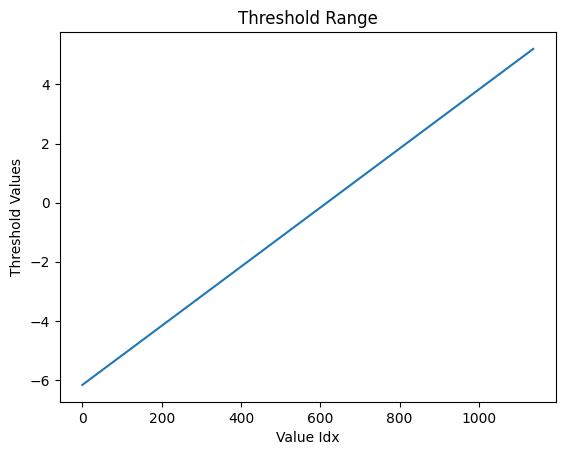

In [204]:
threshold_min = np.min(global_entropy)
threshold_max = np.max(global_entropy)
threshold_step_size = 0.01
threshold_range = np.arange(threshold_min, threshold_max, threshold_step_size)
print(f"Num Threshold Steps: {threshold_range.shape[0]}")

plt.plot(threshold_range)
plt.title("Threshold Range")
plt.xlabel("Value Idx")
plt.ylabel("Threshold Values")

In [205]:
world_size = [-50, 50, -50, 50]
axis_resolution = 0.5

def calculate_preds_w_threshold_test(ge: np.ndarray, threshold: float, dataset):
    
    lidar_data = dataset["lidar_data"][::2]
    occupancy = dataset["occupancy"][::2]

    labels_gt: list[np.ndarray] = []
    preds_list: list[np.ndarray] = []

    for i in range(len(lidar_data)):
        
        points = lidar_data[i]
        labels = occupancy[i]

        points = points[points[:,0] >= world_size[0], :]
        points = points[points[:,0] <= world_size[1], :]
        points = points[points[:,1] >= world_size[2], :]
        points = points[points[:,1] <= world_size[3], :]
        labels = labels[points[:,0] >= world_size[0]]
        labels = labels[points[:,0] <= world_size[1]]
        labels = labels[points[:,1] >= world_size[2]]
        labels = labels[points[:,1] <= world_size[3]]  

        assert points.shape[0] == labels.shape[0]
        assert points.shape[0] > 0

        points[:, 0] -= world_size[0]
        points[:, 1] -= world_size[2]
        points /= axis_resolution
        points = points.astype(np.uint8)

        assert points.shape[0] == labels.shape[0]
        assert points.shape[0] > 0

        e_values = ge[points[:, 1], points[:, 0]]

        assert e_values.shape[0] == points.shape[0]
        
        preds = np.zeros(shape=(points.shape[0]))
        preds[e_values > threshold] = 1

        assert preds.shape[0] == points.shape[0]

        labels_gt.append(labels)
        preds_list.append(preds)

    return np.concatenate(labels_gt), np.concatenate(preds_list)

#### Calculate AUC on A1 Training Data

In [206]:
a1_data_y_true: list[np.ndarray] = []
a1_data_y_pred: list[np.ndarray] = []

for t in threshold_range:
    true, pred = calculate_preds_w_threshold_test(global_entropy, t, a1_test_data)
    
    a1_data_y_true.append(true)
    a1_data_y_pred.append(pred)

In [207]:
tpr_list, fpr_list = calculate_multiple_TP_FP_rates(a1_data_y_true, a1_data_y_pred)

In [208]:
auc = metrics.auc(fpr_list, tpr_list)

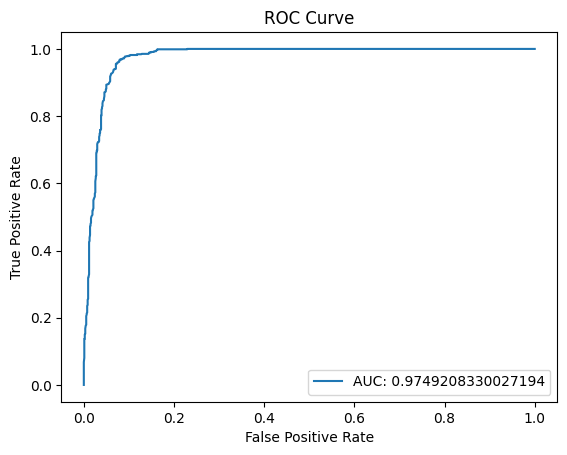

In [209]:
plt.plot(fpr_list, tpr_list, label=f"AUC: {auc}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("toysim-roc-curve.png", dpi=500)

#### Calculate the AUC on the A2 Dataset

In [210]:
a2_data_y_true: list[np.ndarray] = []
a2_data_y_pred: list[np.ndarray] = []

for t in threshold_range:
    true, pred = calculate_preds_w_threshold_test(global_entropy, t, a2_test_data)
    
    a2_data_y_true.append(true)
    a2_data_y_pred.append(pred)

In [211]:
tpr_list, fpr_list = calculate_multiple_TP_FP_rates(a2_data_y_true, a2_data_y_pred)

In [212]:
auc = metrics.auc(fpr_list, tpr_list)

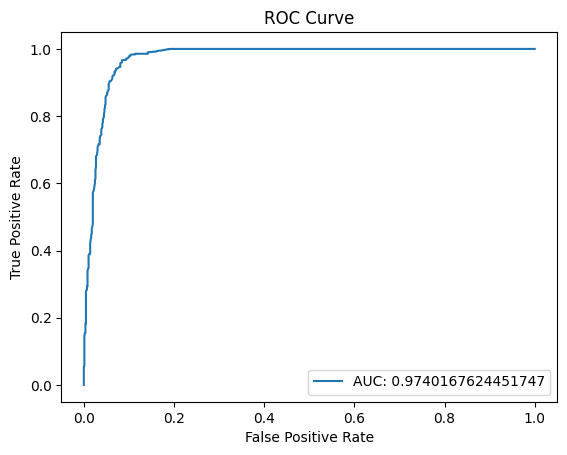

In [213]:
plt.plot(fpr_list, tpr_list, label=f"AUC: {auc}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("toysim-roc-curve.png", dpi=500)

#### Calculate the AUC on the entire testing test

In [214]:
global_data_y_true: list[np.ndarray] = []
global_data_y_pred: list[np.ndarray] = []

global_test_data = copy.deepcopy(a1_test_data)
global_test_data["lidar_data"] = []
global_test_data["occupancy"] = []

for i in range(len(a1_test_data["lidar_data"])):
    global_test_data["lidar_data"].append(np.concatenate([a1_test_data["lidar_data"][i], a2_test_data["lidar_data"][i]]))
    global_test_data["occupancy"].append(np.concatenate([a1_test_data["occupancy"][i], a2_test_data["occupancy"][i]]))

for t in threshold_range:
    true, pred = calculate_preds_w_threshold_test(global_entropy, t, global_test_data)
    
    global_data_y_true.append(true)
    global_data_y_pred.append(pred)

In [215]:
tpr_list, fpr_list = calculate_multiple_TP_FP_rates(global_data_y_true, global_data_y_pred)

In [216]:
auc = metrics.auc(fpr_list, tpr_list)

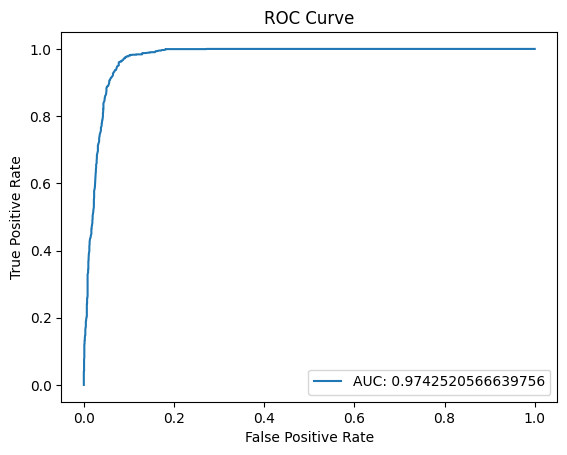

In [217]:
plt.plot(fpr_list, tpr_list, label=f"AUC: {auc}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("toysim-roc-curve.png", dpi=500)

In [221]:
from sklearn.metrics import f1_score, precision_score, recall_score

global_pred = np.zeros(shape=(len(global_data_y_true)))
global_pred[global_entropy[]] = 1

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [222]:
labels, preds = calculate_preds_w_threshold_test(global_entropy, 0, global_test_data)

In [223]:
print(f"F1 Score: {f1_score(labels, preds)}")
print(f"Precision: {precision_score(labels, preds)}")
print(f"Recall: {recall_score(labels, preds)}")

F1 Score: 0.9349462365591398
Precision: 0.9329399141630901
Recall: 0.9369612068965517
